# Imports


In [12]:
import pandas as pd
import numpy as np
import networkx as nx
from typing import List, Dict, Set, Tuple
import re
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from jellyfish import jaro_winkler_similarity
from collections import defaultdict
import tldextract
import phonenumbers
from phonenumbers import NumberParseException
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns

from entity_resolution import preprocess_dataframe

# Preprocessing functions

In [4]:
def preprocess_company_name(name: str) -> str:
    """
    Preprocess company name by:
    1. Converting to lowercase
    2. Removing special characters
    3. Removing common legal entity types
    4. Removing extra whitespace
    5. Converting accented characters to ASCII
    """
    if pd.isna(name):
        return ""

    # Convert to lowercase and remove accents
    name = unidecode(str(name).lower())

    # Remove common legal entity types
    legal_entities = [
        "llc",
        "ltd",
        "inc",
        "corp",
        "corporation",
        "co",
        "company",
        "limited",
        "incorporated",
        "gmbh",
        "ag",
        "sa",
        "srl",
        "bv",
        "nv",
        "spa",
        "plc",
        "pte",
        "pvt",
    ]

    # Remove legal entity types that are separate words
    words = name.split()
    words = [w for w in words if w not in legal_entities]
    name = " ".join(words)

    # Remove special characters but keep spaces
    name = re.sub(r"[^a-z0-9\s]", "", name)

    # Remove extra whitespace
    name = " ".join(name.split())

    return name


def preprocess_phone(phone: str, default_region: str = "US") -> str:
    """
    Preprocess phone number using phonenumbers library:
    1. Parse and normalize the number
    2. Return national number as a string (without country code)
    3. Handle invalid/missing inputs gracefully
    """
    if pd.isna(phone) or not phone or str(phone).strip() == "":
        return None 

    try:
        parsed = phonenumbers.parse(str(phone), default_region)
        
        if not phonenumbers.is_possible_number(parsed):
            return None
        
        national_number = str(parsed.national_number)
        if len(national_number) < 7:
            return None
        
        return national_number
    
    except NumberParseException:
        cleaned = re.sub(r"[^0-9]", "", str(phone))
        if len(cleaned) < 7:
            return None
        return cleaned


def preprocess_location(location: str) -> list:
    """
    Preprocess the Location column by:
    1. Handling missing values
    2. Splitting multiple locations on "|"
    3. Fixing encoding issues
    4. Parsing into structured components
    5. Normalizing text fields (lowercase, clean special characters, standardize terms)
    Returns a list of dictionaries, one per location.
    """
    if pd.isna(location) or not location or str(location).strip() == "":
        return []

    locations = str(location).split("|")
    processed_locations = []

    # Standardize common terms
    street_replacements = {
        "street": "st", "avenue": "ave", "boulevard": "blvd",
        "road": "rd", "drive": "dr", "lane": "ln", "highway": "hwy"
    }

    for loc in locations:
        parts = [part.strip() for part in loc.split(",")]
        if len(parts) < 8:  # Expecting 8 fields (Country Code, Country, ..., Lat, Lon)
            continue

        parts = [unicodedata.normalize("NFC", part) for part in parts]

        try:
            latitude = float(parts[7]) if parts[7] else None
        except ValueError:
            latitude = None  # Set to None if conversion fails

        try:
            longitude = float(parts[8]) if parts[8] else None
        except ValueError:
            longitude = None  # Set to None if conversion fails

        # Structure the location
        loc_dict = {
            "country_code": parts[0],
            "country": parts[1],
            "state": parts[2],
            "city": parts[3],
            "postal_code": parts[4],
            "street": parts[5],
            "street_number": parts[6],
            "latitude": latitude,
            "longitude": longitude
        }

        # Text normalization for string fields
        for key in ["country_code", "country", "state", "city", "street"]:
            if loc_dict[key]:
                loc_dict[key] = loc_dict[key].lower()
                loc_dict[key] = re.sub(r"[^a-z0-9\s\-]", "", loc_dict[key])
                loc_dict[key] = " ".join(loc_dict[key].split())

        # Standardize street terms
        for old, new in street_replacements.items():
            loc_dict["street"] = loc_dict["street"].replace(old, new)

        # Clean postal code
        if loc_dict["postal_code"]:
            loc_dict["postal_code"] = re.sub(r"[^a-z0-9]", "", loc_dict["postal_code"].lower())

        # Clean street number
        if loc_dict["street_number"]:
            loc_dict["street_number"] = re.sub(r"[^0-9]", "", loc_dict["street_number"])

        processed_locations.append(loc_dict)

    return processed_locations


def preprocess_website(url: str) -> str:
    if pd.isna(url):
        return ""
    ext = tldextract.extract(url)
    sub = ext.subdomain if ext.subdomain else ""
    if sub:
        if sub =="www":
            return ext.domain
        if "www." in sub:
            sub = sub.replace("www.", "")
            if ext.domain == "business":
                return sub
            return f"{sub}.{ext.domain}"
        
    return ext.domain


def preprocess_dataframe(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    df_processed = df.copy()

    original_values = {
        "company_name": df["company_name"].tolist(),
        "company_legal_names": df["company_legal_names"].tolist(),
        "company_commercial_names": df["company_commercial_names"].tolist(),
        "website_url": df["website_url"].tolist(),
        "primary_phone": df["primary_phone"].tolist(),
        "main_address_raw_text": df["main_address_raw_text"].tolist(),
    }

    df_processed["company_name_processed"] = df["company_name"].apply(
        preprocess_company_name
    )
    df_processed["company_legal_names_processed"] = df["company_legal_names"].apply(
        preprocess_company_name
    )
    df_processed["company_commercial_names_processed"] = df[
        "company_commercial_names"
    ].apply(preprocess_company_name)

    df_processed["phone_processed"] = df["primary_phone"].apply(preprocess_phone)
    df_processed["website_processed"] = df["website_url"].apply(preprocess_website)
    df_processed["processed_locations"] = df["locations"].apply(preprocess_location)
    
    df_processed["name_variations"] = df_processed.apply(
        lambda x: " | ".join(
            filter(
                None,
                [
                    x["company_name_processed"],
                    x["company_legal_names_processed"],
                    x["company_commercial_names_processed"],
                ],
            )
        ),
        axis=1,
    )

    return df_processed, original_values



# Blocking function

In [19]:
def create_blocks(df: pd.DataFrame) -> Dict[str, Set[int]]:
    """
    Create blocks based on different blocking keys using preprocessed data.
    Returns a dictionary where keys are blocking keys and values are sets of indices.
    """
    blocks = {}

    df_sorted = df.sort_values("company_name_processed")

    # Create blocks by first word of company name
    current_word = None
    current_block = set()

    for idx, row in df_sorted.iterrows():
        name = row["company_name_processed"]
        if not name:
            continue

        words = name.split()
        if not words:
            continue

        first_word = words[0]
        if len(first_word) <= 2:  # Skip very short words
            continue

        # save the previous block if it has multiple records
        if current_word and current_word != first_word:
            if len(current_block) > 1:
                block_key = f"name_first_word_{current_word}"
                blocks[block_key] = current_block.copy()
            current_block = set()

        current_word = first_word
        current_block.add(idx)

    if current_word and len(current_block) > 1:
        block_key = f"name_first_word_{current_word}"
        blocks[block_key] = current_block


    # Block by website domain (only for companies with websites)
    website_mask = df["website_processed"].notna() & (df["website_processed"] != "")
    website_df = df[website_mask]

    for idx, website in website_df["website_processed"].items():
        if not website:
            continue

        block_key = f"website_{website}"
        if block_key not in blocks:
            blocks[block_key] = set()
        blocks[block_key].add(idx)

    # Block by phone number prefix (only for companies with phone numbers)
    phone_mask = df["phone_processed"].notna() & (df["phone_processed"] != "")
    phone_df = df[phone_mask]

    for idx, phone in phone_df["phone_processed"].items():
        if not phone or len(phone) < 3:
            continue

        prefix = phone[:3]
        block_key = f"phone_{prefix}"
        if block_key not in blocks:
            blocks[block_key] = set()
        blocks[block_key].add(idx)

    # Block by location (country + city)
    # Filter out rows with no valid locations
    location_mask = df["processed_locations"].str.len() > 0
    location_df = df[location_mask].copy()

    country_city_blocks = {}
    geo_blocks = {}

    for idx, row in location_df.iterrows():
        for loc in row["processed_locations"]:
            # Country + City blocking
            country = loc["country"]
            city = loc["city"]
            if country and city:
                location_key = (country, city)
                if location_key not in country_city_blocks:
                    country_city_blocks[location_key] = set()
                country_city_blocks[location_key].add(idx)

            # Geospatial blocking
            latitude = loc["latitude"]
            longitude = loc["longitude"]
            if latitude is not None and longitude is not None:
                rounded_lat = round(latitude, 2)
                rounded_lon = round(longitude, 2)
                geo_key = (rounded_lat, rounded_lon)
                if geo_key not in geo_blocks:
                    geo_blocks[geo_key] = set()
                geo_blocks[geo_key].add(idx)

    # Add Country + City blocks
    for (country, city), indices in country_city_blocks.items():
        if len(indices) < 2:
            continue
        block_key = f"location_{country}_{city}".replace(" ", "_")
        blocks[block_key] = indices

    # Add Geospatial blocks
    for (rounded_lat, rounded_lon), indices in geo_blocks.items():
        if len(indices) < 2:  
            continue
        block_key = f"geo_{rounded_lat}_{rounded_lon}"
        blocks[block_key] = indices

    # Block by industry/sector
    industry_mask = df["main_industry"].notna() & df["main_sector"].notna()
    industry_df = df[industry_mask]

    for (industry, sector), group in industry_df.groupby(
        ["main_industry", "main_sector"]
    ):
        if len(group) < 2:
            continue

        block_key = f"industry_{industry}_{sector}".replace(" ", "_")
        blocks[block_key] = set(group.index)


    # Block by email domain
    generic_domains = {
        "gmail.com", "yahoo.com", "hotmail.com", "outlook.com", "aol.com",
        "icloud.com", "mail.com", "protonmail.com", "gmx.com", "zoho.com",
        "yandex.com", "live.com", "msn.com", "inbox.com", "me.com"
    }

    # Filter out rows with missing primary_email
    email_mask = df["primary_email"].notna()
    email_df = df[email_mask].copy()

    # Extract email domain
    def extract_domain(email: str) -> str:
        try:
            return email.split("@")[1].lower().strip()
        except (IndexError, AttributeError):
            return None

    email_df["email_domain"] = email_df["primary_email"].apply(extract_domain)

    # Filter out generic domains and invalid domains
    email_df = email_df[
        (email_df["email_domain"].notna()) & 
        (~email_df["email_domain"].isin(generic_domains))
    ]

    email_blocks = {}

    for idx, row in email_df.iterrows():
        domain = row["email_domain"]
        if domain:
            if domain not in email_blocks:
                email_blocks[domain] = set()
            email_blocks[domain].add(idx)

    for domain, indices in email_blocks.items():
        if len(indices) < 2:  
            continue
        block_key = f"email_domain_{domain.replace('.', '_')}"
        blocks[block_key] = indices

    # Filter out blocks with only one company
    blocks = {k: v for k, v in blocks.items() if len(v) > 1}

    # Filter out large blocks (more than 100 companies)
    blocks = {k: v for k, v in blocks.items() if len(v) <= 100}

    return blocks

# Block Analyzer + find matches

In [7]:
def analyze_blocks(blocks: Dict[str, Set[int]], df: pd.DataFrame) -> None:
    """Analyze and print statistics about the blocks."""
    print("\nBlock Analysis:")
    print(f"Total number of blocks: {len(blocks)}")

    block_sizes = [len(indices) for indices in blocks.values()]
    print(f"Average block size: {np.mean(block_sizes):.2f}")
    print(f"Max block size: {max(block_sizes)}")
    print(f"Min block size: {min(block_sizes)}")

    # Count records in blocks
    records_in_blocks = set().union(*blocks.values())
    print(f"Total unique records in blocks: {len(records_in_blocks)}")
    print(
        f"Percentage of records in blocks: {(len(records_in_blocks) / len(df)) * 100:.2f}%"
    )

    # Count blocks by type
    block_types = {}
    for key in blocks.keys():
        block_type = key.split("_")[0]
        block_types[block_type] = block_types.get(block_type, 0) + 1

    print("\nBlocks by type:")
    for block_type, count in sorted(
        block_types.items(), key=lambda x: x[1], reverse=True
    ):
        print(f"{block_type}: {count} blocks")

    # Analyze block sizes distribution
    size_ranges = [(2, 5), (6, 10), (11, 20), (21, 50), (51, 100), (101, float("inf"))]
    print("\nBlock size distribution:")
    for start, end in size_ranges:
        count = sum(1 for size in block_sizes if start <= size <= end)
        print(f"{start}-{int(end) if end != float('inf') else '∞'}: {count} blocks")


def compute_similarity(name1: str, name2: str) -> float:
    """
    Compute similarity between two company names using multiple metrics.
    Returns a weighted combination of similarity scores.
    """
    if not name1 or not name2:
        return 0.0

    # For very short names (1-2 words), use Jaro-Winkler
    words1 = name1.split()
    words2 = name2.split()
    if len(words1) <= 2 and len(words2) <= 2:
        return jaro_winkler_similarity(name1, name2)

    # For longer names, use a combination of metrics
    # 1. TF-IDF cosine similarity for overall text similarity
    vectorizer = TfidfVectorizer(
        min_df=1,
        analyzer="char_wb",
        ngram_range=(2, 3),
        lowercase=True,
        strip_accents="unicode",
    )
    try:
        tfidf_matrix = vectorizer.fit_transform([name1, name2])
        cosine_sim = (tfidf_matrix * tfidf_matrix.T).A[0, 1]
    except:
        cosine_sim = 0.0

    # 2. Jaro-Winkler for character-level differences
    jw_sim = jaro_winkler_similarity(name1, name2)

    # 3. Word overlap ratio
    words1_set = set(words1)
    words2_set = set(words2)
    overlap = len(words1_set.intersection(words2_set))
    word_overlap = overlap / max(len(words1_set), len(words2_set))


    if len(words1) > 3 or len(words2) > 3:
        # For longer names, give more weight to TF-IDF
        return 0.5 * cosine_sim + 0.3 * jw_sim + 0.2 * word_overlap
    else:
        # For shorter names, give equal weight to all metrics
        return 0.4 * cosine_sim + 0.3 * jw_sim + 0.3 * word_overlap


def find_matches(df, threshold=0.85):  # Lowered base threshold
    """Find matching companies using blocking and multiple similarity metrics"""
    
    blocks = create_blocks(df)

    # thresholds
    industry_thresholds = {
        "Restaurants": 0.80, 
        "Accommodation": 0.80,
        "Real Estate - Agents & Managers": 0.85,
        "Finishing Contractors": 0.85,
        "General Contractors & Heavy Construction": 0.85,
        "Default": threshold,  # Default threshold for unknown industries
    }

    
    matches = []
    processed_pairs = set()  
    similarity_cache = {}

    sorted_blocks = sorted(blocks.items(), key=lambda x: len(x[1]))

    for block_key, indices in sorted_blocks:
        if len(indices) < 2:
            continue

        indices_list = list(indices)

        max_comparisons = 50 
        for i in range(len(indices_list)):
            idx1 = indices_list[i]
            company1 = df.loc[idx1, "company_name"]
            industry1 = df.loc[idx1, "main_industry"]

            if pd.isna(company1):
                continue

            threshold = industry_thresholds.get(
                industry1, industry_thresholds["Default"]
            )

            name1_variations = df.loc[idx1, "name_variations"].split(" | ")

            for j in range(i + 1, min(i + max_comparisons + 1, len(indices_list))):
                idx2 = indices_list[j]
                company2 = df.loc[idx2, "company_name"]
                industry2 = df.loc[idx2, "main_industry"]

                if pd.isna(company2):
                    continue

                pair_key = tuple(sorted([str(company1), str(company2)]))
                if pair_key in processed_pairs:
                    continue
                processed_pairs.add(pair_key)

                name2_variations = df.loc[idx2, "name_variations"].split(" | ")

                max_similarity = 0
                for name1 in name1_variations:
                    for name2 in name2_variations:
                        if not name1 or not name2:
                            continue

                        cache_key = tuple(sorted([name1, name2]))
                        if cache_key in similarity_cache:
                            similarity = similarity_cache[cache_key]
                        else:
                            similarity = compute_similarity(name1, name2)
                            similarity_cache[cache_key] = similarity

                        max_similarity = max(max_similarity, similarity)
                        if max_similarity >= threshold:
                            break
                    if max_similarity >= threshold:
                        break

                if max_similarity >= threshold:
                    country1 = df.loc[idx1, "main_country_code"]
                    country2 = df.loc[idx2, "main_country_code"]
                    website1 = df.loc[idx1, "website_processed"]
                    website2 = df.loc[idx2, "website_processed"]

                    if pd.isna(country1) or pd.isna(country2):
                        continue

                    if country1 != country2:
                        if max_similarity < 0.95:
                            continue

                    if pd.notna(industry1) and pd.notna(industry2):
                        if industry1 != industry2:
                            if not are_related_industries(industry1, industry2):
                                if max_similarity < 0.95:  # Lowered from 0.99
                                    continue

                    # Website validation
                    if website1 and website2 and website1 == website2:
                        max_similarity = min(1.0, max_similarity + 0.05)

                    matches.append(
                        {
                            "company1": company1,
                            "company2": company2,
                            "similarity": max_similarity,
                            "block_key": block_key,
                            "company1_processed": df.loc[
                                idx1, "company_name_processed"
                            ],
                            "company2_processed": df.loc[
                                idx2, "company_name_processed"
                            ],
                            "idx1": idx1,
                            "idx2": idx2,
                        }
                    )

    G = nx.Graph()

    # edges with similarity scores
    for match in matches:
        G.add_edge(
            match["idx1"],
            match["idx2"],
            similarity=match["similarity"],
            company1=match["company1"],
            company2=match["company2"],
            company1_processed=match["company1_processed"],
            company2_processed=match["company2_processed"],
        )

    # Find connected components using minimum spanning tree
    components = []
    for component in nx.connected_components(G):
        # Create subgraph for this component
        subgraph = G.subgraph(component)
        # Find minimum spanning tree to ensure strongest connections
        mst = nx.minimum_spanning_tree(subgraph)
        # Add component with its MST
        components.append((component, mst))

    component_mapping = {}
    for i, (component, _) in enumerate(components):
        for idx in component:
            component_mapping[idx] = i

    # Update matches with component information and actual similarity scores
    for match in matches:
        comp_id = component_mapping[match["idx1"]]
        component, mst = components[comp_id]
        match["component_id"] = comp_id
        match["component_size"] = len(component)

        if mst.has_edge(match["idx1"], match["idx2"]):
            match["similarity"] = mst[match["idx1"]][match["idx2"]]["similarity"]

    # Sort matches by similarity score
    matches.sort(key=lambda x: x["similarity"], reverse=True)
    return matches, components, component_mapping


def are_related_industries(industry1: str, industry2: str) -> bool:
    """Check if two industries are related based on predefined hierarchies."""
    industry_hierarchies = {
        "Food Service": ["Restaurants", "Cafes", "Food Service"],
        "Construction": [
            "General Contractors & Heavy Construction",
            "Finishing Contractors",
            "Construction",
        ],
        "Real Estate": [
            "Real Estate - Agents & Managers",
            "Real Estate",
            "Property Management",
        ],
        "Hospitality": ["Accommodation", "Hotels", "Hospitality"],
    }

    for category, industries in industry_hierarchies.items():
        if industry1 in industries and industry2 in industries:
            return True
    return False


def merge_records(
    df: pd.DataFrame, components: List[Tuple[Set[int], nx.Graph]]
) -> pd.DataFrame:
    """
    Merge records within components to create more complete records.
    For each component, creates a new record with the most complete information.
    """
    merged_records = []

    for component, _ in components:  # Unpack the component and mst tuple
        component_indices = list(component)

        component_records = df[df.index.isin(component_indices)]

        if len(component_records) == 0:
            continue

        merged_record = component_records.iloc[0].copy()

        for column in df.columns:
            if column in ["company_name", "company_name_processed", "name_variations"]:
                continue

            values = component_records[column].dropna()

            if len(values) > 0:
                # For numeric fields, take the maximum value
                if pd.api.types.is_numeric_dtype(df[column]):
                    merged_record[column] = values.max()
                # For categorical fields, take the most common value
                elif pd.api.types.is_string_dtype(df[column]):
                    merged_record[column] = values.mode()[0]
                # For lists (like industries, sectors), combine unique values
                elif isinstance(values.iloc[0], list):
                    unique_values = set()
                    for value in values:
                        if isinstance(value, list):
                            for item in value:
                                if isinstance(item, dict):
                                    unique_values.add(str(item))
                                else:
                                    unique_values.add(item)
                    merged_record[column] = list(unique_values)
                # For dictionaries, keep the first non-empty one
                elif isinstance(values.iloc[0], dict):
                    non_empty_dicts = [v for v in values if v]
                    if non_empty_dicts:
                        merged_record[column] = non_empty_dicts[0]
                    else:
                        merged_record[column] = {}
                else:
                    merged_record[column] = values.iloc[0]

        all_variations = set()
        for _, record in component_records.iterrows():
            if pd.notna(record["name_variations"]):
                all_variations.update(record["name_variations"].split(" | "))
        merged_record["name_variations"] = " | ".join(sorted(all_variations))

        processed_names = component_records["company_name_processed"].dropna()
        if len(processed_names) > 0:
            merged_record["company_name_processed"] = max(processed_names, key=len)

        merged_records.append(merged_record)

    return pd.DataFrame(merged_records)


def create_unique_companies_df(
    df: pd.DataFrame,
    matches: List[Dict],
    components: List[Tuple[Set, nx.Graph]],
    component_mapping: Dict,
) -> pd.DataFrame:
    """Create a DataFrame with one row per unique company."""
    merged_df = merge_records(df, components)

    match_counts = defaultdict(int)
    for match in matches:
        comp_id = component_mapping[match["idx1"]]
        match_counts[comp_id] += 1

    merged_df["match_count"] = merged_df.index.map(lambda x: match_counts[x])

    return merged_df




# Create Blocks

In [10]:
print("Loading dataset...")
df = pd.read_parquet("./veridion_entity_resolution_challenge.snappy.parquet")
print(f"Loaded {len(df)} companies")

print("\nPreprocessing data...")
df, original_values = preprocess_dataframe(df)

print("\nCreating blocks...")
blocks = create_blocks(df)

print("\nAnalyzing blocks...")
analyze_blocks(blocks, df)

Loading dataset...
Loaded 33446 companies

Preprocessing data...

Creating blocks...

Analyzing blocks...

Block Analysis:
Total number of blocks: 23257
Average block size: 5.87
Max block size: 100
Min block size: 2
Total unique records in blocks: 33315
Percentage of records in blocks: 99.61%

Blocks by type:
geo: 6690 blocks
website: 5243 blocks
name: 4822 blocks
location: 4449 blocks
email: 1138 blocks
phone: 863 blocks
industry: 52 blocks

Block size distribution:
2-5: 16594 blocks
6-10: 4759 blocks
11-20: 1130 blocks
21-50: 606 blocks
51-100: 168 blocks
101-∞: 0 blocks


# Analyze Blocks

C:\Users\david\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


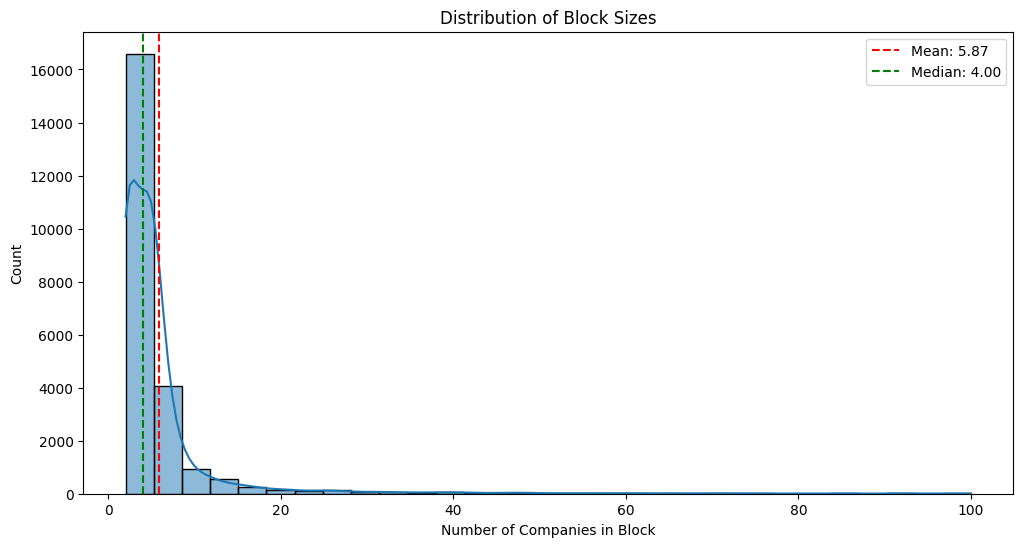

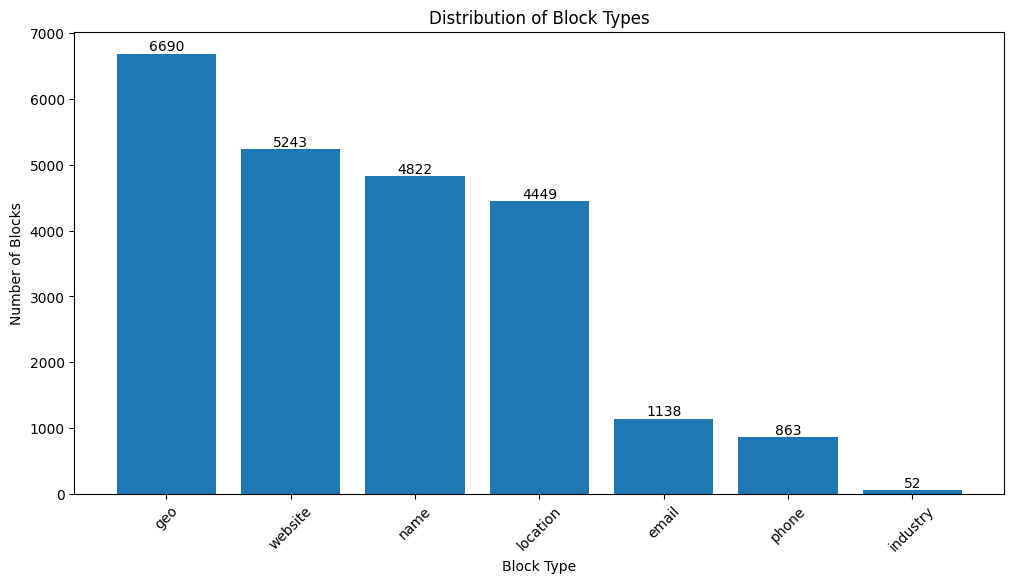

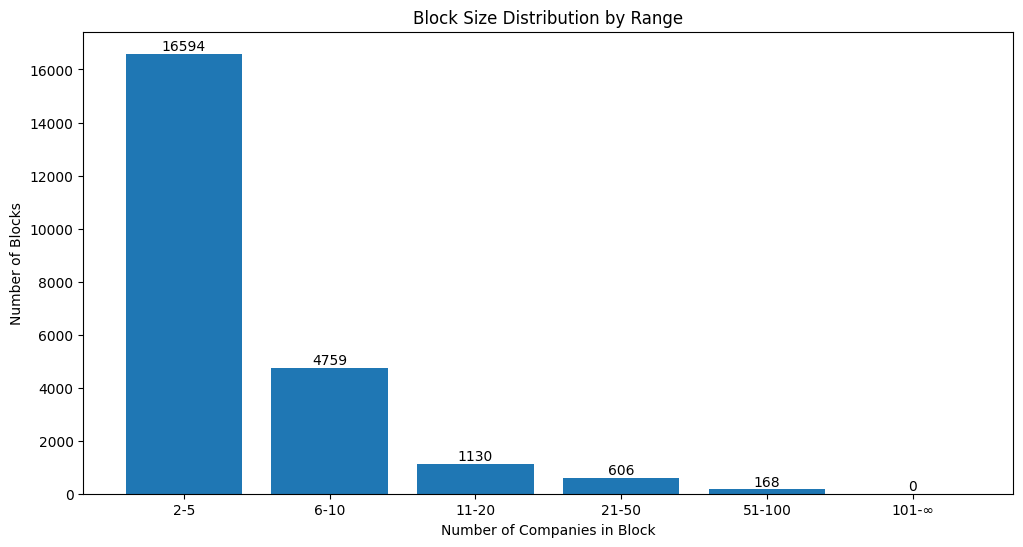

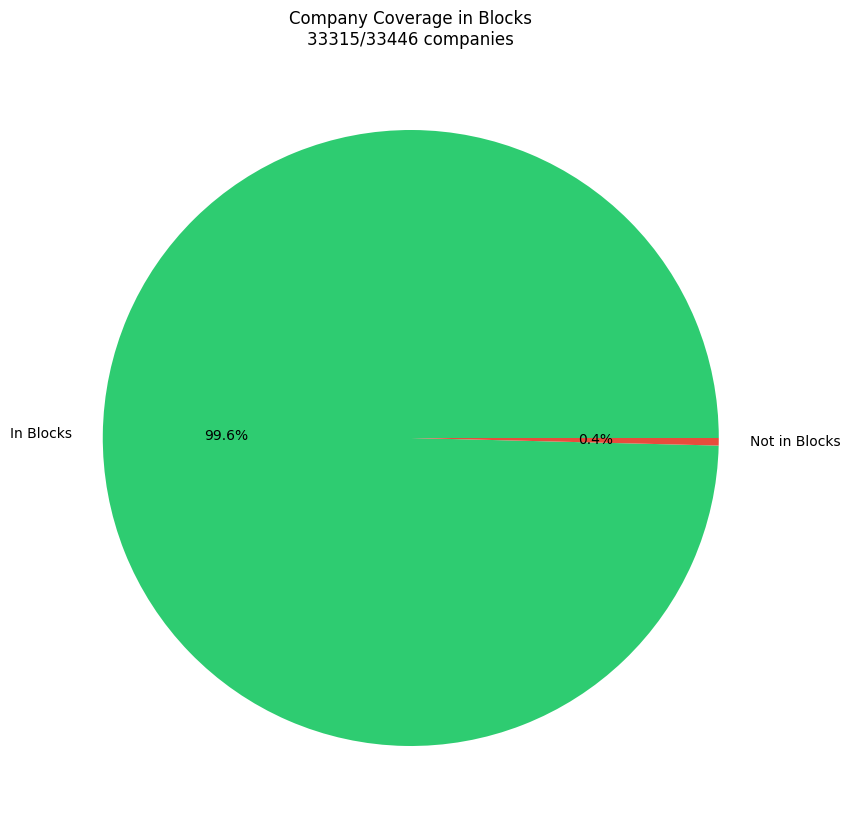

In [15]:
def plot_block_size_distribution(blocks: Dict[str, Set[int]]):
    """Plot the distribution of block sizes."""
    block_sizes = [len(indices) for indices in blocks.values()]

    plt.figure(figsize=(12, 6))

    sns.histplot(data=block_sizes, bins=30, kde=True)

    plt.title("Distribution of Block Sizes")
    plt.xlabel("Number of Companies in Block")
    plt.ylabel("Count")

    plt.axvline(
        np.mean(block_sizes),
        color="red",
        linestyle="--",
        label=f"Mean: {np.mean(block_sizes):.2f}",
    )

    plt.axvline(
        np.median(block_sizes),
        color="green",
        linestyle="--",
        label=f"Median: {np.median(block_sizes):.2f}",
    )

    plt.legend()

    plt.show()

    plt.close()


def plot_block_types(blocks: Dict[str, Set[int]]):
    """Plot the distribution of block types."""
    # Count blocks by type
    block_types = defaultdict(int)
    for key in blocks.keys():
        block_type = key.split("_")[0]
        block_types[block_type] += 1

    plt.figure(figsize=(12, 6))

    sorted_types = dict(sorted(block_types.items(), key=lambda x: x[1], reverse=True))

    bars = plt.bar(sorted_types.keys(), sorted_types.values())

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
        )

    plt.title("Distribution of Block Types")
    plt.xlabel("Block Type")
    plt.ylabel("Number of Blocks")
    plt.xticks(rotation=45)

    plt.show()


    plt.close()


def plot_block_size_ranges(blocks: Dict[str, Set[int]]):
    """Plot the distribution of block sizes in ranges."""
    block_sizes = [len(indices) for indices in blocks.values()]

    size_ranges = [(2, 5), (6, 10), (11, 20), (21, 50), (51, 100), (101, float("inf"))]

    range_counts = []
    range_labels = []
    for start, end in size_ranges:
        count = sum(1 for size in block_sizes if start <= size <= end)
        range_counts.append(count)
        range_labels.append(f'{start}-{int(end) if end != float("inf") else "∞"}')

    plt.figure(figsize=(12, 6))

    bars = plt.bar(range_labels, range_counts)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
        )

    plt.title("Block Size Distribution by Range")
    plt.xlabel("Number of Companies in Block")
    plt.ylabel("Number of Blocks")

    plt.show()
    plt.close()


def plot_block_coverage(blocks: Dict[str, Set[int]], total_companies: int):
    """Plot the coverage of companies in blocks."""
    records_in_blocks = set().union(*blocks.values())

    plt.figure(figsize=(10, 10))

    labels = ["In Blocks", "Not in Blocks"]
    sizes = [len(records_in_blocks), total_companies - len(records_in_blocks)]
    colors = ["#2ecc71", "#e74c3c"]

    plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%")
    plt.title(
        f"Company Coverage in Blocks\n{len(records_in_blocks)}/{total_companies} companies"
    )
    plt.show()
    plt.close()


def create_all_visualizations(blocks: Dict[str, Set[int]], total_companies: int):

    plot_block_size_distribution(blocks)
    plot_block_types(blocks)
    plot_block_size_ranges(blocks)
    plot_block_coverage(blocks, total_companies)



create_all_visualizations(blocks, len(df))

# Matching + Merging

In [16]:
print("\nFinding potential matches...")
matches, components, component_mapping = find_matches(df)

matches_df = pd.DataFrame(matches)
matches_df.to_csv("matches.csv", index=False)
print(f"\nSaved {len(matches)} matches to matches.csv")


Finding potential matches...

Saved 12269 matches to matches.csv


## Save new dataset with unique companies

In [17]:
# Create DataFrame of unique companies
print("\nCreating DataFrame of unique companies...")
unique_companies_df = create_unique_companies_df(
    df, matches, components, component_mapping
)

# Save to CSV
try:
    output_file = "unique_companies.csv"
    print(f"\nSaving unique companies to {output_file}...")
    unique_companies_df.to_csv(output_file, index=False)
    print(f"Saved {len(unique_companies_df)} unique companies to {output_file}")
except:
    print("Error at saving unique_companies.csv")
    
# Save to parquet
try:
    unique_companies_df.to_parquet("unique_companies.parquet", engine="pyarrow")
except:
    print("Cant save as parquet file ):")

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total companies in dataset: {len(df)}")
print(f"Companies with matches: {len(unique_companies_df)}")
print(f"Total number of matches found: {len(matches)}")
print(
    f"Average matches per company: {unique_companies_df['match_count'].mean():.2f}"
)
print(f"Maximum matches for a company: {unique_companies_df['match_count'].max()}")


Creating DataFrame of unique companies...

Saving unique companies to unique_companies.csv...
Saved 6264 unique companies to unique_companies.csv

Summary Statistics:
Total companies in dataset: 33446
Companies with matches: 6264
Total number of matches found: 12269
Average matches per company: 0.81
Maximum matches for a company: 141


# Matching stats

Loading results...

Creating visualizations...


C:\Users\david\AppData\Local\Temp\ipykernel_24108\1282320929.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
C:\Users\david\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\david\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


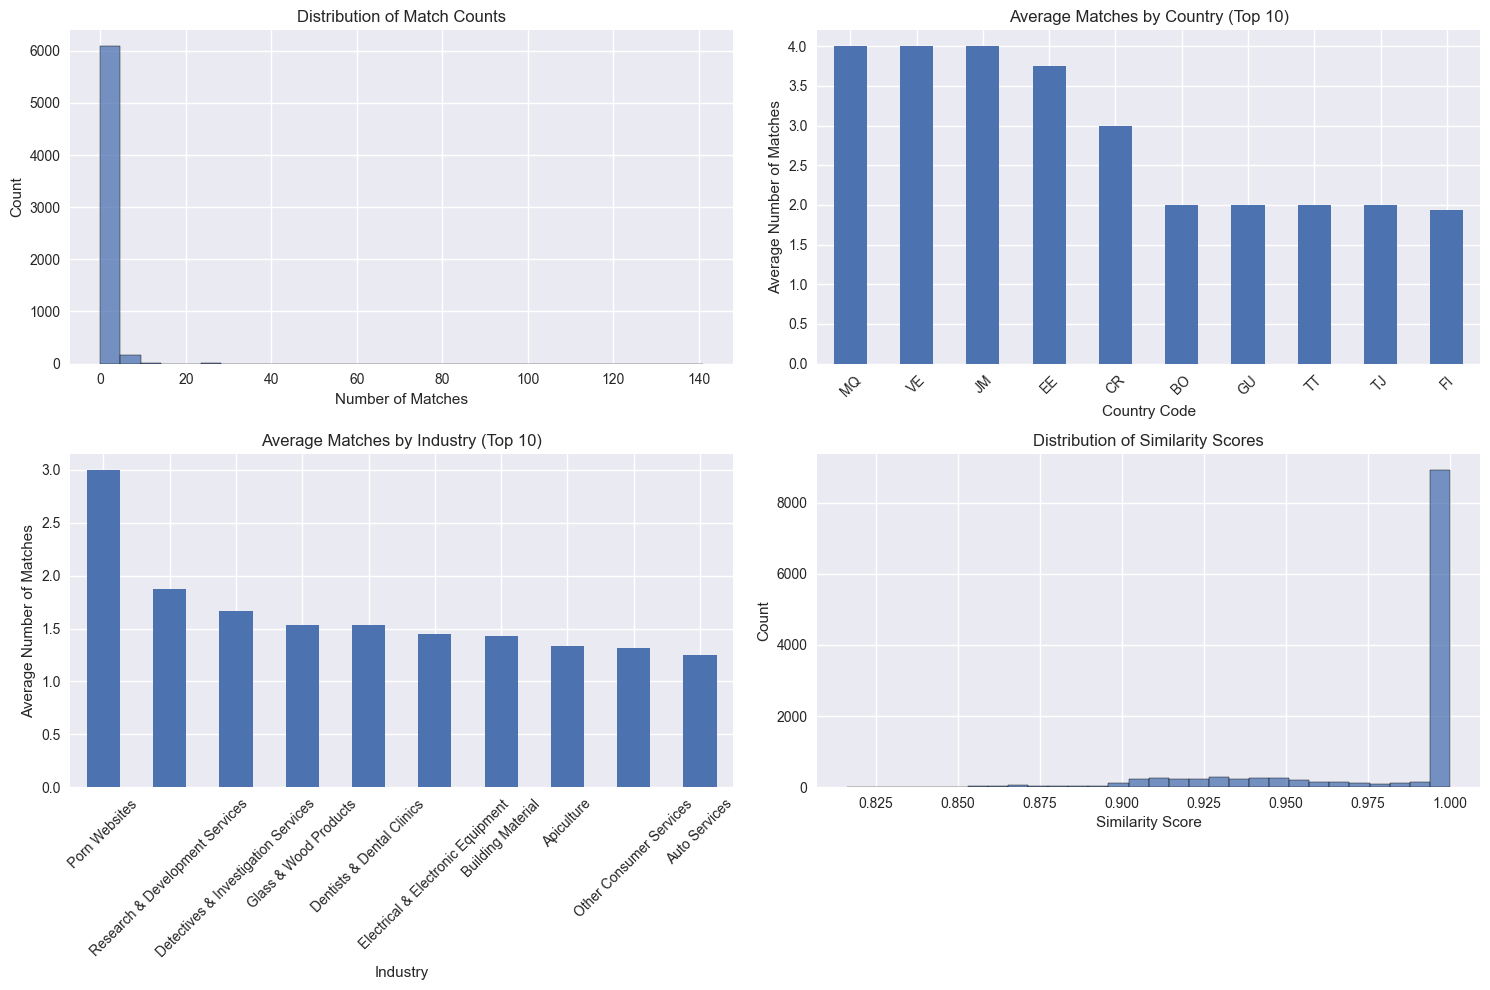


Analyzing match quality...

Match Quality Report
Total number of matches: 12269
Number of unique companies: 6264
Exact matches (similarity = 1.0): 8421
High similarity matches (>= 0.95): 9944

Top 5 Countries by Match Count:
US: 1543 matches
GB: 555 matches
DE: 407 matches
BR: 244 matches
CA: 243 matches

Top 5 Industries by Match Count:
Restaurants: 142 matches
Therapy & Alternative Medicine: 113 matches
Hospitals & Clinics: 107 matches
Accommodation: 102 matches
Real Estate - Agents & Managers: 86 matches

Similarity Score Distribution:
0.90-0.92: 51 matches (0.4%)
0.93-0.94: 23 matches (0.2%)
0.95-0.96: 21 matches (0.2%)
0.97-0.98: 12 matches (0.1%)
0.99-0.999: 204 matches (1.7%)
1.0: 4403 matches (35.9%)

Validation Statistics:
Matches with same country: 4702 (38.3%)
Matches with same industry: 3578 (29.2%)
Matches with same website: 4492 (36.6%)
Matches with all fields matching: 3416 (27.8%)


In [18]:
def load_results(csv_file: str = "unique_companies.csv") -> pd.DataFrame:
    """Load the results from the CSV file."""
    return pd.read_csv(csv_file)


def visualize_matches(df: pd.DataFrame, matches: List[Dict]):
    """Create visualizations of the matching results."""
    plt.style.use("seaborn")

    fig = plt.figure(figsize=(15, 10))

    # 1. Distribution of match counts
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x="match_count", bins=30)
    plt.title("Distribution of Match Counts")
    plt.xlabel("Number of Matches")
    plt.ylabel("Count")

    # 2. Match counts by country
    plt.subplot(2, 2, 2)
    country_matches = (
        df.groupby("main_country_code")["match_count"]
        .mean()
        .sort_values(ascending=False)
    )
    country_matches.head(10).plot(kind="bar")
    plt.title("Average Matches by Country (Top 10)")
    plt.xlabel("Country Code")
    plt.ylabel("Average Number of Matches")
    plt.xticks(rotation=45)

    # 3. Match counts by industry
    plt.subplot(2, 2, 3)
    industry_matches = (
        df.groupby("main_industry")["match_count"].mean().sort_values(ascending=False)
    )
    industry_matches.head(10).plot(kind="bar")
    plt.title("Average Matches by Industry (Top 10)")
    plt.xlabel("Industry")
    plt.ylabel("Average Number of Matches")
    plt.xticks(rotation=45)

    # 4. Similarity score distribution
    plt.subplot(2, 2, 4)
    similarities = [match["similarity"] for match in matches]
    sns.histplot(similarities, bins=30)
    plt.title("Distribution of Similarity Scores")
    plt.xlabel("Similarity Score")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()
    plt.close()


def analyze_match_quality(matches: List[Dict], df: pd.DataFrame) -> Dict:
    """Analyze the quality of matches based on various criteria."""
    quality_metrics = {
        "total_matches": len(matches),
        "unique_companies": len(df),
        "exact_matches": 0,
        "high_similarity_matches": 0,
        "matches_by_country": defaultdict(int),
        "matches_by_industry": defaultdict(int),
        "similarity_distribution": defaultdict(int),
        "similarity_bins": {
            "0.90-0.92": 0,
            "0.93-0.94": 0,
            "0.95-0.96": 0,
            "0.97-0.98": 0,
            "0.99-0.999": 0,
            "1.0": 0,
        },
        "validation_stats": {
            "country_match": 0,
            "industry_match": 0,
            "website_match": 0,
            "all_fields_match": 0,
        },
    }

    company_info = {}
    for _, row in df.iterrows():
        company_info[row["company_name"]] = {
            "country": row["main_country_code"],
            "industry": row["main_industry"],
            "website": row["website_processed"],
        }

    for match in matches:
        if match["similarity"] == 1.0:
            quality_metrics["exact_matches"] += 1

        # Count high similarity matches
        if match["similarity"] >= 0.95:
            quality_metrics["high_similarity_matches"] += 1

        company1 = match["company1"]
        company2 = match["company2"]

        if company1 not in company_info or company2 not in company_info:
            continue

        company1_country = company_info[company1]["country"]
        company2_country = company_info[company2]["country"]
        if company1_country == company2_country:
            quality_metrics["matches_by_country"][company1_country] += 1
            quality_metrics["validation_stats"]["country_match"] += 1

        company1_industry = company_info[company1]["industry"]
        company2_industry = company_info[company2]["industry"]
        if company1_industry == company2_industry:
            quality_metrics["matches_by_industry"][company1_industry] += 1
            quality_metrics["validation_stats"]["industry_match"] += 1

        company1_website = company_info[company1]["website"]
        company2_website = company_info[company2]["website"]
        if (
            company1_website
            and company2_website
            and company1_website == company2_website
        ):
            quality_metrics["validation_stats"]["website_match"] += 1

        if (
            company1_country == company2_country
            and company1_industry == company2_industry
            and company1_website
            and company2_website
            and company1_website == company2_website
        ):
            quality_metrics["validation_stats"]["all_fields_match"] += 1

        similarity = match["similarity"]
        if similarity == 1.0:
            quality_metrics["similarity_bins"]["1.0"] += 1
        elif similarity >= 0.99:
            quality_metrics["similarity_bins"]["0.99-0.999"] += 1
        elif similarity >= 0.97:
            quality_metrics["similarity_bins"]["0.97-0.98"] += 1
        elif similarity >= 0.95:
            quality_metrics["similarity_bins"]["0.95-0.96"] += 1
        elif similarity >= 0.93:
            quality_metrics["similarity_bins"]["0.93-0.94"] += 1
        else:
            quality_metrics["similarity_bins"]["0.90-0.92"] += 1

    return quality_metrics


def print_quality_report(metrics: Dict):
    print("\nMatch Quality Report")
    print("=" * 50)
    print(f"Total number of matches: {metrics['total_matches']}")
    print(f"Number of unique companies: {metrics['unique_companies']}")
    print(f"Exact matches (similarity = 1.0): {metrics['exact_matches']}")
    print(f"High similarity matches (>= 0.95): {metrics['high_similarity_matches']}")

    print("\nTop 5 Countries by Match Count:")
    for country, count in sorted(
        metrics["matches_by_country"].items(), key=lambda x: x[1], reverse=True
    )[:5]:
        print(f"{country}: {count} matches")

    print("\nTop 5 Industries by Match Count:")
    for industry, count in sorted(
        metrics["matches_by_industry"].items(), key=lambda x: x[1], reverse=True
    )[:5]:
        print(f"{industry}: {count} matches")

    print("\nSimilarity Score Distribution:")
    for bin_name, count in sorted(metrics["similarity_bins"].items()):
        percentage = (count / metrics["total_matches"]) * 100
        print(f"{bin_name}: {count} matches ({percentage:.1f}%)")

    print("\nValidation Statistics:")
    total_matches = metrics["total_matches"]
    print(
        f"Matches with same country: {metrics['validation_stats']['country_match']} ({metrics['validation_stats']['country_match']/total_matches*100:.1f}%)"
    )
    print(
        f"Matches with same industry: {metrics['validation_stats']['industry_match']} ({metrics['validation_stats']['industry_match']/total_matches*100:.1f}%)"
    )
    print(
        f"Matches with same website: {metrics['validation_stats']['website_match']} ({metrics['validation_stats']['website_match']/total_matches*100:.1f}%)"
    )
    print(
        f"Matches with all fields matching: {metrics['validation_stats']['all_fields_match']} ({metrics['validation_stats']['all_fields_match']/total_matches*100:.1f}%)"
    )



print("Loading results...")
df = load_results()

matches = pd.read_csv("matches.csv").to_dict("records")

print("\nCreating visualizations...")
visualize_matches(df, matches)

print("\nAnalyzing match quality...")
quality_metrics = analyze_match_quality(matches, df)

print_quality_report(quality_metrics)